## Triangulating and plotting 

In this notebook we show how to read the numpy record array that contains the raw data and the 
analysis of the predictability of each point. The raw data has been checked to ensure that there are no duplicate points (where duplicates were found due to re-occupation of sites, the moho values have been averaged) and therefore can be triangulated.

The package that is used to grid the data on the sphere is `stripy`, a wrapping of the STRIPACK and SSRFPACK
routines of Renka (1997a,b) by Louis Moresi and Ben Mather which is available using `pip install stripy`

The litho 1.0 dataset (Pasyanos et al, 2014) is also made available through an
extension of `stripy` available using `pip install litho1pt0`. The moho for this 
model in the region of interest is plotted below.

**Note:** this triangulation process is not required for the surface models as it is already provided. The 
relevant triangulation is available as `surface_model.gridF`

--- 

Notebooks in this section:

   - [A1-RawData-ConvertAndSave.ipynb](A1-RawData-ConvertAndSave.ipynb)
   - [A2-RawData-PlotQualityInformation.ipynb](A2-RawData-PlotQualityInformation.ipynb)
   - [A3-TriangulatingAndinterpolating.ipynb](A3-TriangulatingAndinterpolating.ipynb)
   - [A4-PlottingMohoAndMohoSlope.ipynb](A4-PlottingMohoAndMohoSlope.ipynb)
   - [A5-Interactive3DPlot.ipynb](A5-Interactive3DPlot.ipynb)
   - [A6-ConvertModels2RegularXYZ.ipynb](A6-ConvertModels2RegularXYZ.ipynb)



In [1]:
%matplotlib inline

import os.path as path
import stripy as stripy
import numpy as np

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
 
import litho1pt0


In [2]:
## These are the original data 

import miller_alaskamoho_srl2018 as alaskamoho

mohoraw     = alaskamoho.MohoErr
mohorawgrid = stripy.sTriangulation(np.radians(mohoraw['lon']), np.radians(mohoraw['lat']), tree=True, permute=False)

print(mohoraw.dtype)


[('lon', '<f8'), ('lat', '<f8'), ('moh', '<f8'), ('xxx', '<f8'), ('stn', 'O'), ('min_err', '<f8'), ('mean_err', '<f8'), ('variance', '<f8'), ('q_score', '<f8')]


### Cartopy contour map of triangulated surface / associated data

`cartopy` applies geographical transformations to the `matplotlib` package. 
For triangulated data, the `matplotlib.contourf`, and `matplotlib.contour` 
functions. 

We prefer to interpolate the data using `stripy` explicitly rather than passing this
task to matplotlib. 

Note that we mask out regions where our resolution is poor by setting the values
there to an underflow value (with an associated, transparent colour). The quality
parameter is provided as part of the model, but when plotting the raw data, 
such a measure can be constructed by examining how the density of data points maps to 
the fine grid. (See below).




In [3]:
## It is useful to map everything to a regular triangulation for plotting 

## Define starting grid

grid1r = stripy.spherical_meshes.icosahedral_mesh(include_face_points=False, refinement_levels=8, tree=True)

## Drop points outside the region of interest

angles = grid1r.angular_separation( grid1r.lons, grid1r.lats, np.radians(-158.0) * np.ones_like(grid1r.lons), 
                                   np.radians(62.0) * np.ones_like(grid1r.lats) ) 

nodes = np.where(angles < np.radians(20.0))

lons1 = grid1r.lons[nodes]%(2.0*np.pi)
lats1 = grid1r.lats[nodes]

# identify points within X degrees of a data point

near_nodes, distances = mohorawgrid.nearest_vertex(lons1, lats1) 
nodes = np.where(distances < 0.075)[0]

# # Now identify points within triangles

# i, err = datagrid.interpolate(lons1, lats1, np.ones_like(datagrid.lons))
# nodes = np.where(err==0)

gridF = stripy.sTriangulation(lons1[nodes]%(2.0*np.pi), lats1[nodes], permute=True)

# Use this as a quality measure 

distances_k, near_nodes = mohorawgrid.nearest_vertices(gridF.lons, gridF.lats, k=10) 
distances = distances_k.mean(axis=1)
interpolation_quality_d1 = np.maximum(0.0, 1.0 - 1.0*distances / distances.mean())
interpolation_quality_d2 = np.maximum(0.0, 1.0 - 2.0*distances / distances.mean())



In [4]:
gridF_interpolation, err = mohorawgrid.interpolate(gridF.lons, gridF.lats, 
                                                   mohoraw['moh'], order=1)

dx,dy,dz = gridF.gradient_xyz(gridF_interpolation, nit=10)
gridF_slope = np.hypot(dx,dy,dz)

In [5]:
gridF_l1pt0 = 0.001 * litho1pt0.layer_depth(lon=np.degrees(gridF.lons), lat=np.degrees(gridF.lats), layerID='LID-TOP')

In [18]:
def alaska_moho_plot(filename, grid, data, quality, plot_range=[25.0, 50.0], cmap=None, show_bg_image=False ):
    
    goodgrid = grid
    interpolation_quality = quality
    grid_data = data
    if cmap == None:
        cmap = plt.cm.RdYlBu

    fig = plt.figure(figsize=(15, 8), facecolor=None)
    ax1  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))
    ax1.set_extent([-170,-130,50,70])
    ax1.coastlines(resolution="50m",color="#000066", linewidth=0.5, zorder=99)
    
    
    ax1.set_extent([-170,-130,50,70])
    
    try:
        import gdal
        globalsrelief       = gdal.Open("ShadedRelief/GRAY_HR_SR_OB.tif")
        globalsrelief_img   = globalsrelief.ReadAsArray()/255.0  # .transpose(1,2,0)
        globalsrelief_img_q = globalsrelief_img[0:globalsrelief_img.shape[0]//4, 0:globalsrelief_img.shape[1]//4]
        
    except ImportError:
        show_bg_image = False

    if(show_bg_image):
        ax1.imshow(globalsrelief_img_q**0.5, origin='upper', transform=ccrs.PlateCarree(),
                   extent=[-180,-90,45,90], zorder=0, alpha=1.0, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)
  
        

    lons = np.degrees(goodgrid.lons)%360.0
    lats = np.degrees(goodgrid.lats)

    ## Mask by quality
    gdata2 = data.copy()
    gdata2[ quality < 0.05] = -1000000.0

    cnt0=ax1.tricontourf(lons, lats, goodgrid.simplices, gdata2, 
                   cmap=cmap, alpha=1.0, 
                   levels=np.linspace(plot_range[0], plot_range[1], 11),
                   extend="max", 
                   transform=ccrs.PlateCarree(), zorder=10)

    ## Locations of raw data collection

    m = ax1.scatter(mohoraw['lon'], mohoraw['lat'],  color="Black",
                   edgecolor="Black", linewidth=0.5, 
                   marker="+", s=25.0, transform=ccrs.Geodetic(), zorder=25)


    plt.colorbar(ax=ax1, mappable=cnt0, shrink=0.5, extend='max', drawedges=False )

    fig.savefig(filename, dpi=600)


 

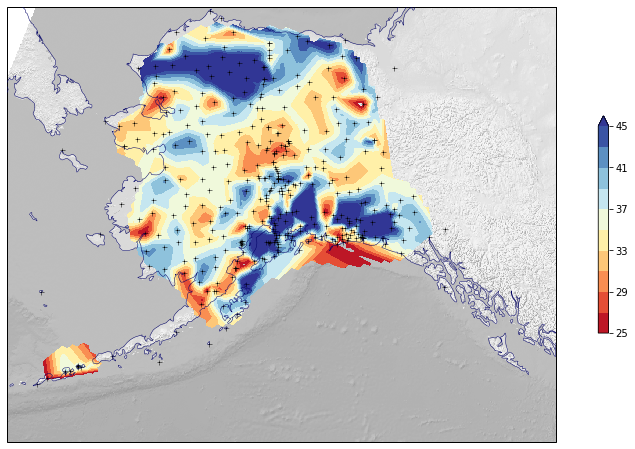

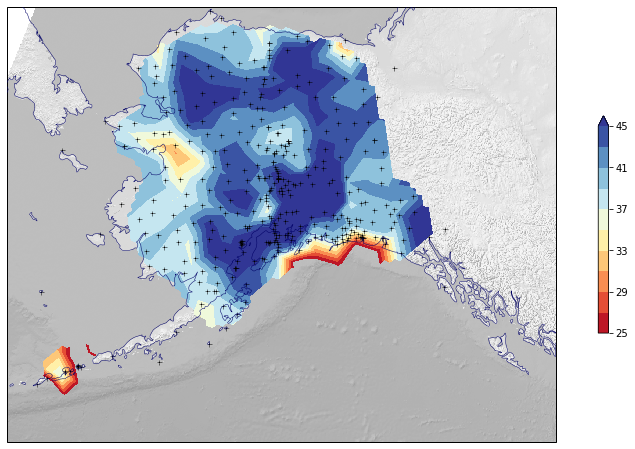

In [19]:
alaska_moho_plot("Images/AlaskaMohoRaw.png", gridF, gridF_interpolation, 
            interpolation_quality_d2, plot_range=[25, 45], cmap=plt.cm.RdYlBu, show_bg_image=True)


alaska_moho_plot("Images/AlaskaMoho_l1pt0.png", gridF, gridF_l1pt0, 
            interpolation_quality_d2, plot_range=[25, 45], cmap=plt.cm.RdYlBu, show_bg_image=True)

## Slope

Triangulation means that we can differentiate the surface although
the result is not especially illuminating (note that we have
chosen a scale that anticipates later results



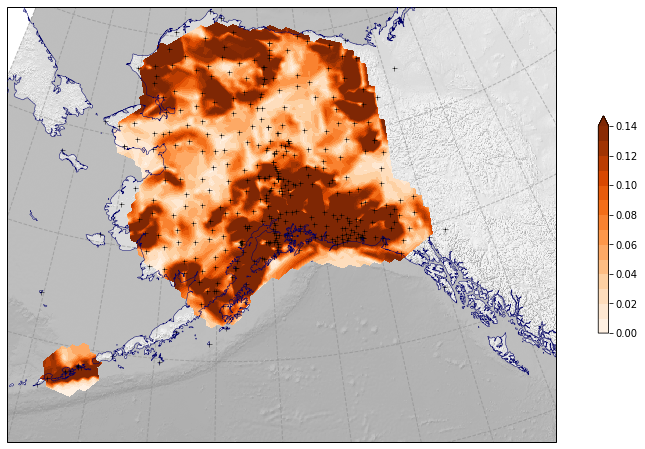

In [17]:
def alaska_moho_slope_plot(filename, grid, data, quality, 
                           plot_range=[25.0, 50.0], cmap=None, show_bg_image=False ):
    
    goodgrid = grid
    interpolation_quality = quality
    grid_data = data
    if cmap == None:
        cmap = plt.cm.RdYlBu

    fig = plt.figure(figsize=(15, 8), facecolor=None)
    ax1  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))
    ax1.set_extent([-170,-130,50,70])
    ax1.coastlines(resolution="10m",color="#000066", linewidth=0.5, zorder=99)
    
    grat = cartopy.feature.NaturalEarthFeature(category="physical", scale="10m",
                                    name="graticules_5")

    
    try:
        import gdal
        globalsrelief       = gdal.Open("ShadedRelief/GRAY_HR_SR_OB.tif")
        globalsrelief_img   = globalsrelief.ReadAsArray()/255.0  # .transpose(1,2,0)
        globalsrelief_img_q = globalsrelief_img[0:globalsrelief_img.shape[0]//4, 0:globalsrelief_img.shape[1]//4]
        
    except ImportError:
        show_bg_image = False

    if(show_bg_image):
        ax1.imshow(globalsrelief_img_q**0.5, origin='upper', transform=ccrs.PlateCarree(),
                   extent=[-180,-90,45,90], zorder=0, alpha=1.0, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)
  


    
    ax1.add_feature(grat, linewidth=1.0, 
                      linestyle="--",
                      edgecolor="#88888888", 
                      facecolor="None", zorder=2)

        
    lons = np.degrees(goodgrid.lons)%360.0
    lats = np.degrees(goodgrid.lats)

    gdata2 = data.copy()
    gdata2[ quality < 0.05] = -1000000.0


    cnt0=ax1.tricontourf(lons, lats, goodgrid.simplices, gdata2, 
                   cmap=cmap, alpha=1.0, 
                   levels=np.linspace(0.0, 0.14, 15),
                   extend="max", 
                   transform=ccrs.PlateCarree(), zorder=10)
    
    

    ## Locations of raw data collection

    m = ax1.scatter(mohoraw['lon'], mohoraw['lat'],  color="Black",
                   edgecolor="Black", linewidth=0.5, 
                   marker="+", s=25.0, transform=ccrs.Geodetic(), zorder=25)


    plt.colorbar(ax=ax1, mappable=cnt0, shrink=0.5, drawedges=False )



alaska_moho_slope_plot("AlaskaMohoSlope", gridF, gridF_slope / 6371, 
            interpolation_quality_d2, plot_range=[0, 0.14], cmap=plt.cm.Oranges, show_bg_image=True)

